## **Foreword**

##### Last change: 9. February 2022

### Ensuring that the test data is never touched before statistical procedures have been used to select the final model is essential. In addition, all methods to be compared should have the same database and not see different data due to random shuffles during the split or in the cross-validation. This is to be achieved here by strict separation of the data already when reading in the data. This script also does the pre-treatment and then stores the data blocks on the disk.

In [1]:
# Import general stuff
import os, re, numpy as np, pandas as pd

# 1-D interpolation
from scipy.interpolate import interp1d

# Shuffling data for more randomness
from sklearn.utils import shuffle

# Cross-validation
from sklearn.model_selection import cross_val_score, KFold

# Graphical output
import matplotlib.pyplot as plt

In [2]:
# Use spectral range from [450 to 700) nm with 1 nm step size
wavelength = np.arange(450, 700, 1)

# Number of cross-validation folds
folds = 10

# Quantity for analysis (and corresponding extension in filename and description)
#quantity = ["no-plug_Rd", "Diffuse reflection"]
#quantity = ["no-plug_Td", "Diffuse transmission"]
#quantity = ["no-plug_Tu", "Unscattered transmission"]
#quantity = ["with-plug_Rd", "Total reflection"]
quantity = ["with-plug_Tt", "Total transmission"]

# Parameters for histograms
parameters = ["ctHb", "fO2Hb", "fHHb", "fCOHb", "fMetHb", "Hematocrit"]

### **Test set**

In [3]:
# Allocate memory for file list
filesTest = list()

# Search for '*.oxy' files in directories
for file in os.listdir("../data/test"):
    if file.endswith(".oxy"):
        path = os.path.join("../data/test", file)
        filesTest.append(path)

# Count number of '*.oxy' files
numTest = len(filesTest)

# Additional information
print(str(numTest) + " samples in test set")

45 samples in test set


In [4]:
# Allocate memory for reference values; each line represents one measurement and columns represent reference values
y_test = np.zeros((numTest, len(parameters)))

# Generate list of file names
filenames = [file for file in filesTest]

# Loop through measurement files
for index in range(0, numTest):
    # Get name of current file
    filename = filenames[index]

    # Open text file read-only
    with open(filename, "rt") as f:
        # Loop through lines in current measurement file
        for line in f:
            # Loop through parameter list
            for parameter in range(0, len(parameters)):
                # Total hemoglobin concentration is handled in a different way
                if parameters[parameter] == "ctHb":
                    # Extract value for total hemoglobin concentration
                    value = re.findall('  ' + parameters[parameter] + ": (\d+\.\d+) g/dL", line)
                elif parameters[parameter] == "Hematocrit":
                    # Extract value for hematocrit
                    value = re.findall('  ' + parameters[parameter] + ": (\d+\.\d+)", line)
                else:
                    # Extract value for other parameters
                    value = re.findall('  ' + parameters[parameter] + ": (\d+\.\d+) %", line)

                # Value exists?
                if value:
                    # Save current value to data matrix
                    y_test[index, parameter] = float(value[0])

try:
    # Convert total hemoglobin concentration from g/dL to g/L
    y_test[:, parameters.index("ctHb")] *= 10
except ValueError:
    pass

# Show table of counts
print(np.shape(y_test))

(45, 6)


In [5]:
# Allocate memory for optical spectra
X_test = np.zeros((numTest, wavelength.shape[0]))

# Loop through spectra
for index in range(0, numTest):
    # Get file in file list
    file = filesTest[index]

    # Read in wavelegth and counts vectors, ignore header lines
    sample = pd.read_csv(file[:-4] + "/sample_" + quantity[0] + ".txt", skiprows = 7, sep = r"\s+")

    # Generate function for linear 1-D interpolation
    f = interp1d(sample.iloc[:, 0], sample.iloc[:, 1], kind = 'linear', fill_value = "extrapolate")

    # Read in wavelegth and counts vectors, ignore header lines
    noSample = pd.read_csv(file[:-4] + "/no-sample_" + quantity[0] + ".txt", skiprows = 9, sep = r"\s+")

    # Generate function for linear 1-D interpolation
    g = interp1d(noSample.iloc[:, 0], noSample.iloc[:, 3], kind = 'linear', fill_value = "extrapolate")

    # Subtract reference counts from sample counts
    X_test[index, :] = f(wavelength) / g(wavelength)

# Show table of counts
print(np.shape(X_test))

(45, 250)


In [14]:
# There is no transmission smaller 0 %
X_test[X_test < 0] = 0

# There is no transmission greater 100 %
X_test[X_test > 1] = 1

In [15]:
# Create new figure
plt.figure()

# Change figure font
font = {'family' : 'monospace', 'weight' : 'normal', 'size' : 14}
plt.rc('font', **font)

for index in range(numTest):
    # Plot current measurement data
    plt.plot(wavelength, X_test[index, :] * 100.0)

# Set axis limits
plt.xlim(450, 700)
plt.ylim(0, 100)

# Set axis labels
plt.xlabel("Wavelength in nm")
plt.ylabel("Normalised intensity in %")

# Set title
plt.title(quantity[1])

# Adjust axis
plt.axis([min(wavelength), max(wavelength), 0.0, 100.0])

# Enable grid
plt.grid()

# Create directories if necessary
if not os.path.exists("../figures"):
    os.makedirs("../figures")

# Export figure to PDF file
plt.savefig("../figures/test spectra.pdf")    

# Finally show figure
plt.show(block = True)

In [16]:
# Export test data
np.savetxt("../data/X_test.csv", X_test, delimiter=",")
np.savetxt("../data/y_test.csv", y_test, delimiter=",")

### Never touch this until the final model is selected!

## **Training set**

In [17]:
# Allocate memory for file list
filesTraining = list()

# Search for '*.oxy' files in directories
for file in os.listdir("../data/train"):
    if file.endswith(".oxy"):
        path = os.path.join("../data/train", file)
        filesTraining.append(path)

# Count number of '*.oxy' files
numTraining = len(filesTraining)

# Additional information
print(str(numTraining) + " samples in training set")

358 samples in training set


In [18]:
# Allocate memory for reference values; each line represents one measurement and columns represent reference values
y_raw = np.zeros((numTraining, len(parameters)))

# Generate list of file names
filenames = [file for file in filesTraining]

# Loop through measurement files
for index in range(0, numTraining):
    # Get name of current file
    filename = filenames[index]

    # Open text file read-only
    with open(filename, "rt") as f:
        # Loop through lines in current measurement file
        for line in f:
            # Loop through parameter list
            for parameter in range(0, len(parameters)):
                # Total hemoglobin concentration is handled in a different way
                if parameters[parameter] == "ctHb":
                    # Extract value for total hemoglobin concentration
                    value = re.findall('  ' + parameters[parameter] + ": (\d+\.\d+) g/dL", line)
                else:
                    # Extract value for other parameters
                    value = re.findall('  ' + parameters[parameter] + ": (\d+\.\d+) %", line)

                # Value exists?
                if value:
                    # Save current value to data matrix
                    y_raw[index, parameter] = float(value[0])

try:
    # Convert total hemoglobin concentration from g/dL to g/L
    y_raw[:, parameters.index("ctHb")] *= 10
except ValueError:
    pass

# Show table of counts
print(np.shape(y_raw))

(358, 6)


In [19]:
# Allocate memory for optical spectra
X_raw = np.zeros((numTraining, wavelength.shape[0]))

# Loop through spectra
for index in range(0, numTraining):
    # Get file in file list
    file = filesTraining[index]

    # Read in wavelegth and counts vectors, ignore header lines
    sample = pd.read_csv(file[:-4] + "/sample_" + quantity[0] + ".txt", skiprows = 7, sep = r"\s+")

    # Generate function for linear 1-D interpolation
    f = interp1d(sample.iloc[:, 0], sample.iloc[:, 1], kind = 'linear', fill_value = "extrapolate")

    # Read in wavelegth and counts vectors, ignore header lines
    noSample = pd.read_csv(file[:-4] + "/no-sample_" + quantity[0] + ".txt", skiprows = 9, sep = r"\s+")

    # Generate function for linear 1-D interpolation
    g = interp1d(noSample.iloc[:, 0], noSample.iloc[:, 3], kind = 'linear', fill_value = "extrapolate")

    # Subtract reference counts from sample counts
    X_raw[index, :] = f(wavelength) / g(wavelength)

# Show table of counts
print(np.shape(X_raw))

(358, 250)


In [20]:
# There is no transmission smaller 0 %
X_raw[X_raw < 0] = 0

# There is no transmission greater 100 %
X_raw[X_raw > 1] = 1

In [21]:
# Generate random order of samples
indices = np.arange(X_raw.shape[0])
shuffle(indices, random_state = 42)

# Shuffle spectra and values the same way
X_train = X_raw[indices]
y_train = y_raw[indices]

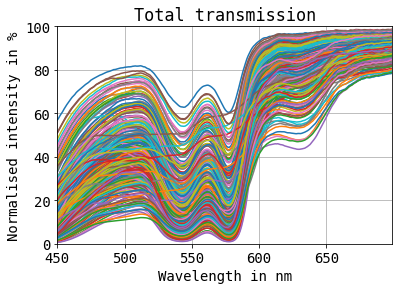

In [22]:
# Create new figure
plt.figure()

# Change figure font
font = {'family' : 'monospace', 'weight' : 'normal', 'size' : 14}
plt.rc('font', **font)

for index in range(numTraining):
    # Plot current measurement data
    plt.plot(wavelength, X_train[index, :] * 100.0)

# Set axis limits
plt.xlim(450, 700)
plt.ylim(0, 100)

# Set axis labels
plt.xlabel("Wavelength in nm")
plt.ylabel("Normalised intensity in %")

# Set title
plt.title(quantity[1])

# Adjust axis
plt.axis([min(wavelength), max(wavelength), 0.0, 100.0])

# Enable grid
plt.grid()

# Create directories if necessary
if not os.path.exists("../figures"):
    os.makedirs("../figures")

# Export figure to PDF file
plt.savefig("../figures/training spectra.pdf")    

# Finally show figure
plt.show(block = True)

In [23]:
# Export test data
np.savetxt("../data/X_train.csv", X_train, delimiter=",")
np.savetxt("../data/y_train.csv", y_train, delimiter=",")

In [24]:
# Create 10-fold cross validation splits
kf = KFold(n_splits=folds, random_state=None, shuffle=False)

# Create matrices for CV train and validation indices
CV_train_indices = -np.ones((X_train.shape[0], folds))
CV_validate_indices = -np.ones((X_train.shape[0], folds))

i = 0

# Loop through each split
for train_index, validate_index in kf.split(X_train):
    # Put indices into matrices
    CV_train_indices[0:len(train_index), i] = train_index
    CV_validate_indices[0:len(validate_index), i] = validate_index

    # Next split
    i = i + 1

# Remove "empty" rows (which have a value of -1)
CV_train_indices = CV_train_indices[(CV_train_indices != -1).all(axis=1)]
CV_validate_indices = CV_validate_indices[(CV_validate_indices != -1).all(axis=1)]

# Export indices for splits
np.savetxt("../data/CV_train_indices.csv", CV_train_indices, delimiter=",")
np.savetxt("../data/CV_validate_indices.csv", CV_validate_indices, delimiter=",")

## **Data augmentation**

### Data is artificially disturbed by intensity drift, spectral shift and both. This data is used to train k-OPLS and CNN models.

In [25]:
# Data augmentation (intensity drift)
X_train_ID_raw = np.concatenate((X_train * 0.9, X_train, X_train * 1.1), axis=0)
y_train_ID_raw = np.concatenate((y_train, y_train, y_train), axis=0)

# Generate random order of samples
indices = np.arange(X_train_ID_raw.shape[0])
shuffle(indices, random_state = 42)

# Shuffle spectra and values the same way
X_train_ID = X_train_ID_raw[indices]
y_train_ID = y_train_ID_raw[indices]

# Export training data with intensity drift
np.savetxt("../data/X_train_ID.csv", X_train_ID, delimiter=",")
np.savetxt("../data/y_train_ID.csv", y_train_ID, delimiter=",")

In [26]:
# Create matrices for CV train and validation indices
CV_train_ID_indices = -np.ones((X_train_ID.shape[0], folds))
CV_validate_ID_indices = -np.ones((X_train_ID.shape[0], folds))

i = 0

# Loop through each split
for train_index, validate_index in kf.split(X_train_ID):
    # Put indices into matrices
    CV_train_ID_indices[0:len(train_index), i] = train_index
    CV_validate_ID_indices[0:len(validate_index), i] = validate_index

    # Next split
    i = i + 1

# Remove "empty" rows (which have a value of -1)
CV_train_ID_indices = CV_train_ID_indices[(CV_train_ID_indices != -1).all(axis=1)]
CV_validate_ID_indices = CV_validate_ID_indices[(CV_validate_ID_indices != -1).all(axis=1)]

# Export indices for splits
np.savetxt("../data/CV_train_ID_indices.csv", CV_train_ID_indices, delimiter=",")
np.savetxt("../data/CV_validate_ID_indices.csv", CV_validate_ID_indices, delimiter=",")

In [27]:
# Generate function for linear 1-D interpolation
f = interp1d(wavelength, X_train, kind = "linear", fill_value = "extrapolate")

# Data augmentation (spectral shift)
X_train_SS_raw = np.concatenate((f(wavelength - 2.0), X_train, f(wavelength + 2.0)), axis=0)
y_train_SS_raw = np.concatenate((y_train, y_train, y_train), axis=0)

# Generate random order of samples
indices = np.arange(X_train_SS_raw.shape[0])
shuffle(indices, random_state = 42)

# Shuffle spectra and values the same way
X_train_SS = X_train_SS_raw[indices]
y_train_SS = y_train_SS_raw[indices]

# Export training data with intensity drift
np.savetxt("../data/X_train_SS.csv", X_train_SS, delimiter=",")
np.savetxt("../data/y_train_SS.csv", y_train_SS, delimiter=",")

In [28]:
# Create matrices for CV train and validation indices
CV_train_SS_indices = -np.ones((X_train_SS.shape[0], folds))
CV_validate_SS_indices = -np.ones((X_train_SS.shape[0], folds))

i = 0

# Loop through each split
for train_index, validate_index in kf.split(X_train_SS):
    # Put indices into matrices
    CV_train_SS_indices[0:len(train_index), i] = train_index
    CV_validate_SS_indices[0:len(validate_index), i] = validate_index

    # Next split
    i = i + 1

# Remove "empty" rows (which have a value of -1)
CV_train_SS_indices = CV_train_SS_indices[(CV_train_SS_indices != -1).all(axis=1)]
CV_validate_SS_indices = CV_validate_SS_indices[(CV_validate_SS_indices != -1).all(axis=1)]

# Export indices for splits
np.savetxt("../data/CV_train_SS_indices.csv", CV_train_SS_indices, delimiter=",")
np.savetxt("../data/CV_validate_SS_indices.csv", CV_validate_SS_indices, delimiter=",")

In [29]:
# Data augmentation (intensity drift and spectral shift)
X_train_ID_SS_raw = np.concatenate((f(wavelength - 2.0), X_train * 0.9, X_train, X_train * 1.1, f(wavelength + 2.0)), axis=0)
y_train_ID_SS_raw = np.concatenate((y_train, y_train, y_train, y_train, y_train, y_train, y_train), axis=0)

# Generate random order of samples
indices = np.arange(X_train_ID_SS_raw.shape[0])
shuffle(indices, random_state = 42)

# Shuffle spectra and values the same way
X_train_ID_SS = X_train_ID_SS_raw[indices]
y_train_ID_SS = y_train_ID_SS_raw[indices]

# Export training data with intensity drift
np.savetxt("../data/X_train_ID_SS.csv", X_train_ID_SS, delimiter=",")
np.savetxt("../data/y_train_ID_SS.csv", y_train_ID_SS, delimiter=",")

In [30]:
# Create matrices for CV train and validation indices
CV_train_ID_SS_indices = -np.ones((X_train_ID_SS.shape[0], folds))
CV_validate_ID_SS_indices = -np.ones((X_train_ID_SS.shape[0], folds))

i = 0

# Loop through each split
for train_index, validate_index in kf.split(X_train_ID_SS):
    # Put indices into matrices
    CV_train_ID_SS_indices[0:len(train_index), i] = train_index
    CV_validate_ID_SS_indices[0:len(validate_index), i] = validate_index

    # Next split
    i = i + 1

# Remove "empty" rows (which have a value of -1)
CV_train_ID_SS_indices = CV_train_ID_SS_indices[(CV_train_ID_SS_indices != -1).all(axis=1)]
CV_validate_ID_SS_indices = CV_validate_ID_SS_indices[(CV_validate_ID_SS_indices != -1).all(axis=1)]

# Export indices for splits
np.savetxt("../data/CV_train_ID_SS_indices.csv", CV_train_ID_SS_indices, delimiter=",")
np.savetxt("../data/CV_validate_ID_SS_indices.csv", CV_validate_ID_SS_indices, delimiter=",")